# Midterm Assignment, topic 5: Product portfolio choice

> The sequence of tasks below should be performed in order in this
notebook. Feel free to add code and markdown cells, but do not change
cells that contain the assignment tasks.
If the task offers some degree of interpretation (so, don’t tell you what
to do exactly), you are free to interpret it in the way you see fit
best. But remember to explain why you make such and such choice in your answer.

> The grade for the midterm assignment is based on both the code
correctness and code style. The former relates to whether the code
adequately represents the economic model under consideration, and the
latter has to do with how well the code is modularized and organized,
whether appropriate syntax is used, and whether the code is well
documented. [PEP 8](https://www.python.org/dev/peps/pep-0008/)
standard is a good reference for coding style, but will not reduce the
grade.

## Product portfolio choice by a multi-product firm

In this assignment you consider a theoretic model of product portfolio
choice by a multi-product firm in a perfectly competitive market.

### Task 1. Design and implement a Python class to represent the model

In implementing your class follow these steps:

- the class should be initialized (*init*) with the number of products $ n $ and the
  label for the current specification of the model  
- create method *set_prices* which would take a list or a numpy array
  with $ n $ elements to represent the market prices of the products (net of variable cost)  
- create method *add_constraint* which would take a list or a numpy array
  with $ n $ elements and a second argument *const* to represent a technological
  constraint of the firm’s production process given by the linear inequality
  $ \sum_{i=1}^{n} a_i x_i \le C $ (where $ a_i $ and $ C $ are coefficients
  and the constant respectively).  
- create method *remove_constraint* which would take a single index, and remove
  the constraint with this index  
- create method *nr_constraints* without arguments which would return the current
  number of constraints in the model (you can use magic command *@property* to be able
  to treat the output of the method as class property)  
- finally, create the standard methods for sting representation (*repr*) that
  would list all the attributes of the model in a nice human readable way  


All calls to the constraints created by *add_constraint()* should accumulate within the
object, and can only be deleted by calling *remove_constraint()* with an appropriate index.

In [1]:
import numpy as np
from itertools import product

class portfolio_choice():
    """Class that implements portfolio choice"""
    
    def __init__(self, n, label='no name'):
        '''Constructor for the portfolio choice class'''
        self.n, self.label = n, label
        
        self.x = np.zeros((0, self.n))
        self.b = np.zeros(1)
        self.p = np.zeros((0, self.n))
    
    def array_check(self, v):
        '''Checks if array is in the correct format'''
        if isinstance(v, list):
            return np.array(v)
        elif isinstance(v, np.ndarray):
            return v
        else:
            raise TypeError('Wrong type for input array')
        
    def set_prices(self, p):
        '''Take a list or array with 'n' elements represent the market prices
        of the products'''
        
        if not all (p_i >= 0 for p_i in p):
            raise ValueError('Prices must be greater than 0')
        
        self.p = self.array_check(p)
        return self.p
    
    def add_constraint(self, a, b):
        '''Adds a constraint for the production technology'''
        self.a = self.array_check(a)
        self.a = self.a.reshape((1, self.n))
        
        self.x = np.concatenate((self.x, self.a), axis=0)
        self.b = np.append(self.b, b)
    
    def remove_constraint(self, i):
        '''Removes a constraint for the production technology'''
        self.x = np.delete(self.x, i - 1, axis=0)
        self.b = np.delete(self.b, i - 1)
        
    @property
    def nr_constraints(self):
        '''Number of products'''
        return len(self.x)


In [2]:
import unittest

class Portfolio_Choice_Test(unittest.TestCase):
    """Test code for the portfolio choice case"""
    
    def test1(self):
        '''Constraint test'''
        pf = portfolio_choice(3)
        pf.add_constraint([1, 3, 1], 3)
        s = '%s' %pf.x
        self.assertTrue(s == '[[1. 3. 1.]]')
    
    def test2(self):
        '''Constraint test 2'''
        pf = portfolio_choice(3)
        pf.add_constraint([1, 3, 1], 3)
        s = '%s' %pf.b
        self.assertTrue(s == '[0. 3.]')

if __name__ == '__main__':
    unittest.main(argv = ['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


### Task 2. Develop a simple check for consistency of the problem

Before working with a particular parametrization of the model, it is useful to
check if there are any combinations of products in the portfolio
$ (x_1,x_2,\dots,x_n) $ which are consistent with all the constraints.

Implement the following simple algorithm (the full treatment of the problem
can be found, for example, in A.Schrijver “Theory of linear and integer programming”, Sect. 3.7.8).

- choose an upper bound and create a fairly fine grid between zero and this bound  
- systematically loop through all points of the finite hypercube induced by applying the
  grid in each of $ n $ dimensions, in other words, use $ n $ nested loops through
  the points of the grid to enumerate all points of the $ n $-dimensional space
  within the upper bound  
- for each point check all model constraints  
- if a point consistent with all constraints is found, break out of the loops and return
  true for the consistency check (the system of constraints seems consistent)  
- otherwise, return false (the system of constraints seems inconsistent)  


Write a function which takes a model object and returns the result of consistency check.

Call this function before performing any of the tasks below to ensure adequate
functioning of the code.

In [3]:
def consistency_check(model,
                      grid,
                      n, 
                      maxiter=1000):

    candidates = np.array(list(product(grid, repeat=n))) # Change this
    iter_count = 1
    i = 1   # We skip x = [0, 0, ..., 0] which is a trival solution
    
    # Commence iteration
    while (i < len(candidates)) and (i <= maxiter):
        b1 = model.x @ candidates[i]
        if all(b1 <= model.b[1::]): # Fix this
            consistency = 'Consistent! A consistent candidate solution found in iteration number: {} where x = {}'.format(iter_count,candidates[i])
            return consistency
            break
        else:
            iter_count += 1
            i += 1
    else:
        inconsistency = 'Not consistent! Max number of iterations = {} reached'.format(iter_count)
        return inconsistency

In [4]:
class Task2_test(unittest.TestCase):
    '''Test code for Consistency Check function'''
    
    def test_postive(self):
        """Test for positive result"""
        p2 = portfolio_choice(2)
        p2.add_constraint([-1,1], 4)
        p2.add_constraint([2,-1], 8)
        p2.add_constraint([1,2], 14)
        grid = np.linspace(0,10,10)
        a = consistency_check(model=p2, grid=grid, n=2);
        self.assertTrue(a == 'Consistent! A consistent candidate solution found in iteration number: 1 where x = [0.         1.11111111]')
        
if __name__ == '__main__':
    unittest.main(argv = ['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


### Task 3. Graphical representation of 2D problems

Develop a graphical representation of the problem when $ n=2 $, similar to
[this example](https://ds055uzetaobb.cloudfront.net/brioche/uploads/3mbYZ5LMun-linear-programming-proof.png?width=1200).
The diagram should include:

- all constrains represented by thin lines of the same color (i.e. blue)  
- the filled (colored) polygon bounded by the constrains
  (Hint: use alpha<1 for semi-transparent fill, loop at the [polygon](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.patches.Polygon.html) command in matplotlib)  
- the grid squares  
- level curves of the objective function in a contrasting color (i.e. red)  


In defining the coordinates of the polygon marked out by the constrains
you have to compute the intersection points of the lines. Adapt the code form
week 5 assignment which is designed to find intersection points of line segments.

In [5]:
# draft of the line intersection code

def intersect_lines(a1,b1,a2,b2):
    '''Compute the intersection point of two lines a1*x+b1 and a2*x+b2'''
    # unpack parameters as points on two axes
    x11,y11,x12,y12 = 0,b1,-b1/a1,0  # first line
    x21,y21,x22,y22 = 0,b2,-b2/a2,0  # second line
    # form system of equations
    A = np.array([[x12-x11,0,-1,0],[0,x22-x21,-1,0],[y12-y11,0,0,-1],[0,y22-y21,0,-1]])
    b = np.array([-x11,-x21,-y11,-y21])
    try:
        t1,t2,x0,y0 = np.linalg.solve(A,b)
        # lines do intersect if system is solved
        return x0,y0
    except:
        return None

In [6]:
pf = portfolio_choice(2)

pf.add_constraint([1.5,1], 6)
pf.add_constraint([-5,1], -5)
pf.add_constraint([-0.5,1], 4)
pf.add_constraint([2.2,1], 14)
pf.add_constraint([0.2,1], 2)

pf.set_prices([1, 1])

array([1, 1])

In [7]:
x = np.zeros(5)
y = np.zeros(5)

for i in range(4):
    x[i], y[i] = intersect_lines(- pf.x[i][0], pf.b[i + 1], - pf.x[i + 1][0], pf.b[i + 2])
x[4], y[4] = intersect_lines(- pf.x[0][0], pf.b[1], - pf.x[4][0], pf.b[5])

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

verts = [[x[0],y[0]], 
         [x[1], y[1]], 
         [x[2], y[2]], 
         [x[3], y[3]], 
         [x[4], y[4]]]

fig, ax = plt.subplots(figsize=(8,6))

ax.grid()
ax.xaxis.set_ticklabels([])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('none')

ax.set_ylim(-0.5, 8)
ax.set_xlim(-0.5, 8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.vlines(x = 0, ymin = -0.5, ymax = 8, lw=1.8, color='k', alpha=0.4)
ax.hlines(y = 0, xmin = -0.5, xmax = 8, lw=1.8, color='k', alpha=0.4)
ax.text(x[4], y[4], 'Minimum Solution', fontsize = 16, horizontalalignment='right', verticalalignment='center')
ax.text(x[2], y[2], 'Maximum Solution', fontsize = 16)

polygon = Polygon(verts, color = 'blue', alpha=0.1)
ax.add_patch(polygon)

for i in range(4):
    ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], color='b')
ax.plot([x[0], x[4]], [y[0], y[4]], color='b')

z = np.linspace(0, 8, 100)

intercept = np.linspace(4.461538461538462, 9.555555555555554, 5)

for i in range(intercept.size):
    ax.plot(z, - z + intercept[i], color='r')

ax.scatter(x, y, color='k')

plt.show()

<Figure size 800x600 with 1 Axes>

### Task 4. Finding optimal product portfolio

Write the solver function for the model, which would take the model object as
an input and output a vector of quantities of each product to be produced.

Within the function express the problem in terms of linear programming objects
(matrix and vector), and use the linear solver similar to the second part of
week 5 lecture.

Use the following model specification. The $ n=2 $ goods production technology
is restricted by

$$
\begin{cases}
y - x  &\le& 4, \\
2x - y &\le&8,
\end{cases}
$$

In addition, there is a resource constraint given by $ x + 2y \le 14 $.
Do not forget about non-negativity constrains on $ x $ and $ y $.

Finally, let profit be given by $ \pi(x,y) = y + 2x $.

In [9]:
pf2 = portfolio_choice(2)

pf2.add_constraint([-1, 1], 4)
pf2.add_constraint([1, 2], 14)
pf2.add_constraint([2, -1], 8)

pf2.set_prices([2, 1])

from scipy.optimize import linprog

c = - pf2.p # Since maximisation problem
A = pf2.x
b = pf2.b[1::]
    
def outf(args):
    print('iteration %d, current solution %s'%(args['nit'],args['x']))

solution = linprog(c=c,A_ub=A,b_ub=b,method='simplex',callback=outf)
solution

iteration 0, current solution [0. 0.]
iteration 1, current solution [4. 0.]
iteration 2, current solution [6. 4.]
iteration 3, current solution [6. 4.]
iteration 3, current solution [6. 4.]


     con: array([], dtype=float64)
     fun: -16.0
 message: 'Optimization terminated successfully.'
     nit: 3
   slack: array([6., 0., 0.])
  status: 0
 success: True
       x: array([6., 4.])

In [10]:
# THIS SOLUTION IS INDICATIVE ONLY, NEED TO USE THE CLASS!

import numpy as np
from scipy.optimize import linprog

c = np.array([-2,-1])
A = np.array([[-1,1],[2,-1],[1,2],[-1,0],[0,-1]])
b = np.array([4,8,14,0,0])

def outf(args):
    print('iteration %d, current solution %s'%(args['nit'],args['x']))

linprog(c=c,A_ub=A,b_ub=b,method='simplex',callback=outf)

iteration 0, current solution [0. 0.]
iteration 1, current solution [4. 0.]
iteration 2, current solution [6. 4.]
iteration 3, current solution [6. 4.]
iteration 3, current solution [6. 4.]


     con: array([], dtype=float64)
     fun: -16.0
 message: 'Optimization terminated successfully.'
     nit: 3
   slack: array([6., 0., 0., 6., 4.])
  status: 0
 success: True
       x: array([6., 4.])

### Task 5. Plot and analyze the solution

Make a separate function to plot the solution of the model when $ n=2 $:
it should show the polygon in the same way as in Task 3, but instead of collection
of level curves, it should only plot one curve line that corresponds to the
solution of the problem.  Mark the solution with a red dot.

Show the solution under the specification of Task 4.

In [11]:
c = np.zeros(5)
d = np.zeros(5)

c[0], d[0] = 0.0, 0.0
c[1], d[1] = 0.0, 4.0
c[2], d[2] = intersect_lines(-pf2.x[0][0]/pf2.x[0][1], pf2.b[1]/pf2.x[0][1], -pf2.x[1][0]/pf2.x[1][1], pf2.b[2]/pf2.x[1][1])
c[3], d[3] = intersect_lines(-pf2.x[1][0]/pf2.x[1][1], pf2.b[2]/pf2.x[1][1], -pf2.x[2][0]/pf2.x[2][1], pf2.b[3]/pf2.x[2][1])
c[4], d[4] = 4.0, 0.0

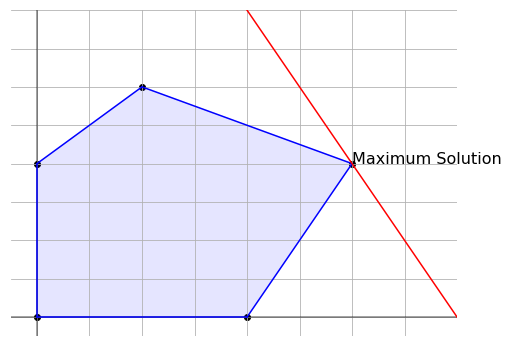

In [12]:
verts = [[c[0], d[0]], 
         [c[1], d[1]], 
         [c[2], d[2]], 
         [c[3], d[3]], 
         [c[4], d[4]]]

fig, ax = plt.subplots(figsize=(8,6))

ax.grid()
ax.xaxis.set_ticklabels([])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks_position('none')

ax.set_ylim(-0.5, 8)
ax.set_xlim(-0.5, 8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.vlines(x = 0, ymin = -0.5, ymax = 8, lw=1.8, color='k', alpha=0.4)
ax.hlines(y = 0, xmin = -0.5, xmax = 8, lw=1.8, color='k', alpha=0.4)
ax.text(c[3], d[3], 'Maximum Solution', fontsize = 16)

polygon2 = Polygon(verts, color = 'blue', alpha=0.1)
ax.add_patch(polygon2)

for i in range(4):
    ax.plot([c[i], c[i + 1]], [d[i], d[i + 1]], color='b')
ax.plot([c[0], c[4]], [d[0], d[4]], color='b')

z = np.linspace(0, 8, 100)

ax.plot(z, - 2 * z + 16, color='r')

ax.scatter(c, d, color='k')

plt.show()

### Task 6. Short analysis

What is the minimum change in product net prices that would lead to a change in the optimal portfolio?
Show this situation graphically.

What are the prices that result in multiple product portfolios being optimal?
Show this situation graphically as well.

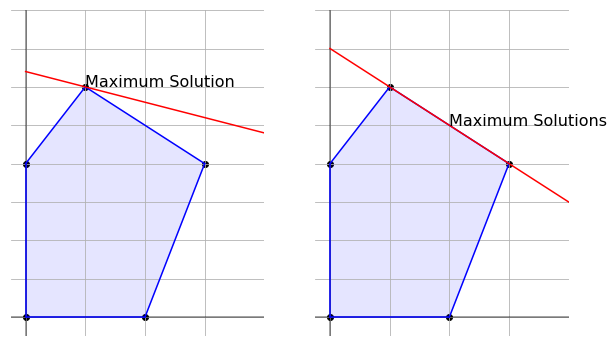

In [13]:
verts = [[c[0], d[0]], 
         [c[1], d[1]], 
         [c[2], d[2]], 
         [c[3], d[3]], 
         [c[4], d[4]]]

fig, ax = plt.subplots(1, 2, figsize=(10,6))

for i in range(ax.size):
    ax[i].grid()
    ax[i].xaxis.set_ticklabels([])
    ax[i].xaxis.set_ticks_position('none')
    ax[i].yaxis.set_ticklabels([])
    ax[i].yaxis.set_ticks_position('none')

    ax[i].set_ylim(-0.5, 8)
    ax[i].set_xlim(-0.5, 8)

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)

    ax[i].vlines(x = 0, ymin = -0.5, ymax = 8, lw=1.8, color='k', alpha=0.4)
    ax[i].hlines(y = 0, xmin = -0.5, xmax = 8, lw=1.8, color='k', alpha=0.4)


    polygon2 = Polygon(verts, color = 'blue', alpha=0.1)
    ax[i].add_patch(polygon2)
    
    ax[i].scatter(c, d, color='k')
    
    for j in range(4):
        ax[i].plot([c[j], c[j + 1]], [d[j], d[j + 1]], color='b')
    ax[i].plot([c[0], c[4]], [d[0], d[4]], color='b')


ax[0].text(c[2], d[2], 'Maximum Solution', fontsize = 16)
ax[1].text(4, 5, 'Maximum Solutions', fontsize = 16, horizontalalignment='left')

z = np.linspace(0, 8, 100)

ax[0].plot(z, - (1/5) * z + (32/5), color='r')
ax[1].plot(z, - (1/2) * z + 7, color='r')

plt.show()

### Task 7. Higher dimensional problems

Specify your own problem with $ n=4 $ products, and solve it using the programmed method.

- Come up with several constrains with economic interpretation  
- Don’t forget about the non-negativity constraints  
- Consider a fixed cost of running the production, and how it would be expressed in the model  